In [2]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from data.make_dataset import ESDCData
from models.esdc_sampling import SamplingModel
from models.derivatives import GPRBFDerivative
from py_esdc.data import window_xy, get_xy_indices, get_3dgrid
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Open Results File

In [12]:
original_data_path = '/media/disk/databases/BACI-CABLAB/low_res_data/'
figures_path = '/home/emmanuel/projects/2019_sakame/reports/figures/'
save_path = '/home/emmanuel/projects/2019_sakame/data/results/'

time = 1
window_size = 5
variable = 'gross_primary_productivity'
# save_name = f"experiment_{variable}.nc"
save_name = f"test_land_surface_temperature.nc"

with xr.open_dataset(save_path + save_name) as xr_results:
    print(xr_results)
    sample_timestamp = xr_results.time.values[0]

<xarray.Dataset>
Dimensions:      (lat: 144, lon: 312, time: 1, window: 1)
Coordinates:
  * lon          (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat          (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
  * time         (time) datetime64[ns] 2010-06-06
  * window       (window) int64 3
    mask         (lat, lon) float32 ...
Data variables:
    labels       (lat, lon, time, window) float64 ...
    sensitivity  (lat, lon, time, window) float64 ...
    predictions  (lat, lon, time, window) float64 ...
Attributes:
    num_training:  2000


## Plot Results

<xarray.DataArray (lat: 144, lon: 312)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ..., 0.176448, 0.168158, 0.153299],
       [     nan,      nan,      nan, ..., 0.181449, 0.169663, 0.156084],
       [     nan,      nan,      nan, ..., 0.178461, 0.168326, 0.156937]])
Coordinates:
  * lon      (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat      (lat) float32 71.375 71.125 70.875 70.625 ... 36.125 35.875 35.625
    time     datetime64[ns] 2010-06-06
    window   int64 3
    mask     (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


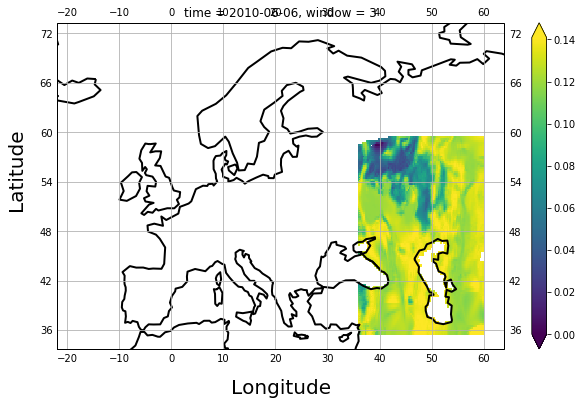

In [13]:
# LABELS

with xr.open_dataset(save_path + save_name) as xr_results:
    
    # select data subset
    subset = xr_results.sensitivity.isel(window=0).isel(time=0).where(xr_results.mask == 1)
    
    print(subset)
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')

    
    p = subset.plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(),
        robust=True, cmap='viridis', vmin=0,
#         cbar_kwargs={'label': subset.gross_primary_productivity.units, 
#                      'format': '%.1f'}
    )
    # cbar = fig.colorbar(p)
    ax.coastlines(linewidth=2)
    ax.gridlines(draw_labels=True)
    ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=20,
            transform=ax.transAxes)
    ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor', fontsize=20,
            transform=ax.transAxes)
    plt.tight_layout()
    save_plt_name = f'{variable}_labels_mean_before_{window_size}'
    plt.savefig(figures_path + save_plt_name + '.png')
    plt.show()